In [79]:
import torch
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from gtda.graphs import KNeighborsGraph
import itertools
from utils import GraphRNN_dataset, GraphRNN_DataSampler
import random

from importlib import reload
import matplotlib.pyplot as plt

from preprocessor import Preprocessor
from preprocessor import draw_network
from preprocessor import get_adj_from_plot

from preprocessor_final_data import Preprocessor
from preprocessor_final_data import draw_network
from preprocessor_final_data import get_adj_from_plot

import preprocessor_final_data 
import os
from torch_geometric.nn import GCNConv

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
import Model3
reload(Model3)
from Model3 import GraphConvolutionalNetwork

In [6]:
print("Gathering data...")
flow_dataset = "../data/daily_county2county_2019_01_01.csv"
epi_dataset = "../data_epi/epidemiology.csv"

Gathering data...


In [80]:
# THIS IS WITH THE NEW PREPROCESSOR FILE (PREPROCESSOR_FINAL_DATA.PY)

print("Preprocessing data...")
# Preprocess the data
print(os.getcwd())
locations_data = "../final_data/locations_data_unique.npy"
epi_dataset = "../final_data/X_normalized.npy"
preproc = preprocessor_final_data.Preprocessor(flow_dataset, epi_dataset, locations_data, plottable=True)

Preprocessing data...
/mnt/c/Users/Victor Gladys/Documents/Master/GraphML/ClassicalModels
(30, 3218, 9)


In [14]:
# GRAPH CONVOLUTIONAL NETWORK BASED ON KRONECKER GRAPH -- TOO MANY PARAMS NOW, TALK TO PEOPLE ABOUT THIS & HOW TO REDUCE

# Define the model parameters
desired_num_params = 2000
input_horizon = 7   # test now with smaller input horizon
prediction_horizon = 1    # test now with smaller prediction horizon

In [81]:
import Model3
reload(Model3)
from Model3 import GraphConvolutionalNetwork

#  Instantiate the model
model = GraphConvolutionalNetwork(desired_num_params, input_horizon, prediction_horizon, preproc)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", num_params)

# Define the loss function and optimizer
num_epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# shuffle the training data randomly
random.shuffle(model.training_data)
random.shuffle(model.testing_data)

Getting the training graph signal...
30 7
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 0
(22533, 22533)
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 3219
(22533, 22533)
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 6438
(22533, 22533)
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 9657
(22533, 22533)
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 12876
(22533, 22533)
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 16095
(22533, 22533)
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 19314
(22533, 22533)
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 22533
(22533, 22533)
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 25752
(22533, 22533)
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 28971
(22533, 22533)
was here
(96598, 96598)
numnnodes p day: 3219 input hor: 7 offset: 32190
(22533, 2253

In [82]:
# TRAINING
train_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    for data in model.training_data:        
        output = model(data) # needs to have shape [num_nodes_pred, num_features]
        # output is of shape [3070] turn into shape [3070, 1] 
        # output = output.view(-1, 1) # I dont think i need because now it is a multidimensional output
        
        loss = model.getLoss(output)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.8f}')



Epoch 1/10, Train Loss: 1.50157666
Epoch 2/10, Train Loss: 1.49246991
Epoch 3/10, Train Loss: 1.48627329
Epoch 4/10, Train Loss: 1.47698534
Epoch 5/10, Train Loss: 1.47887027
Epoch 6/10, Train Loss: 1.47638452
Epoch 7/10, Train Loss: 1.46938324
Epoch 8/10, Train Loss: 1.48080158
Epoch 9/10, Train Loss: 1.47371686
Epoch 10/10, Train Loss: 1.47004914


In [83]:

# Test the model
model.eval()
test_loss = 0.0
predictions = []
targets = []
with torch.no_grad():
    for data in model.testing_data:
        output = model(data) 

        loss = model.getLoss(output)
        test_loss += loss.item()
    test_loss /= len(model.testing_data)

# Compute metrics
print(f'Test Loss: {test_loss:.8f}')
print(model.target_graph_signal_matrix[:, 2])


Test Loss: 0.86431353
tensor([ 0.0257, -0.3163, -0.2455,  ...,  0.0262, -0.1474,  0.0257])


32.534920756109095


/home/victor/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


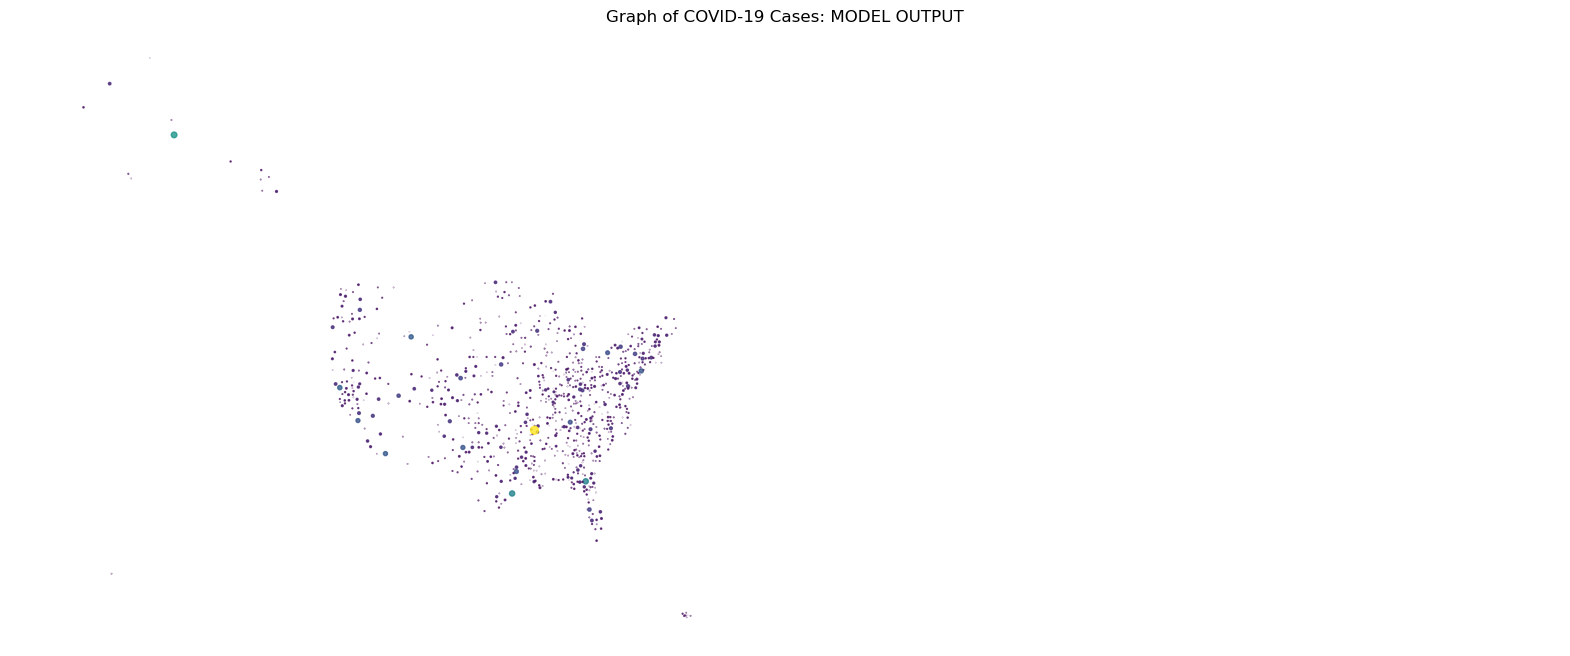

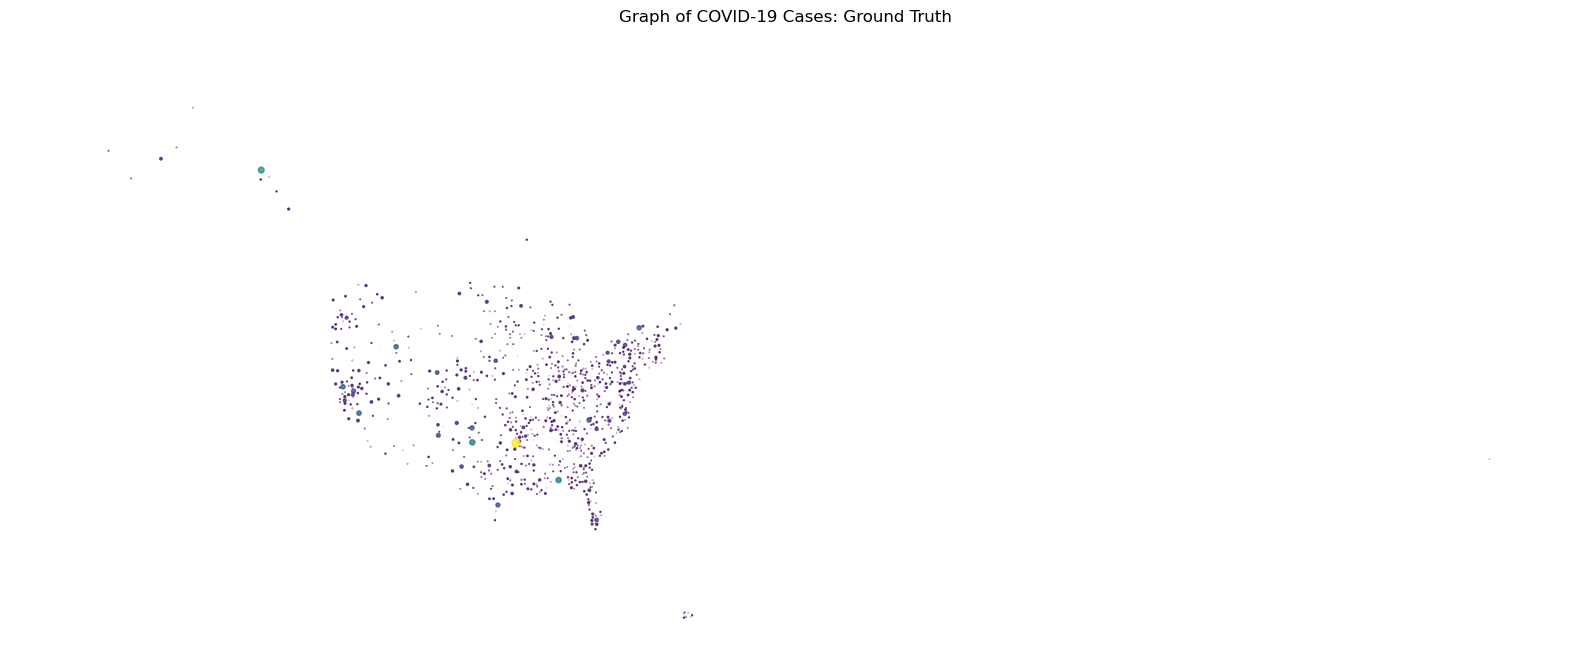

In [84]:
# plot the united states and have these values as the nodes

# get a list of the key values in train_graph_sig
geoid_list_train = list(model.train_graph_sig.keys())
target_graph_signal = model.testing_data[-1][2]
geoid_list_target = list(target_graph_signal.keys())

# make a dictionary where key is geoid_list entry and value is out entry
train_dict = {geoid_list_train[i]: output[i, 2].item() for i in range(len(output))}

target_dict = {i: target_graph_signal[i]['cumulative_confirmed'] for i in geoid_list_target}

# need to get the geographical information on where to put these nodes
# get the geographical information from the preprocessor, 'geoid_o', 'lat_o', 'lng_o' for all the geoids in train_dict
#print(graph_kronecker_whole_df)

# for each geoid_o which is a key in train_dict, get the lat_o and lng_o from the graph_kronecker_whole_df
# then plot the united states and put the values of train_dict as the node values (new_confirmed)
# then compare with the target_dict values

import networkx as nx
import matplotlib.pyplot as plt


# create model output plot
# Create an empty graph
G = nx.Graph()

# Add nodes with attributes
geoid_o = list(train_dict.keys())
print(model.graph_kronecker_whole_df[model.graph_kronecker_whole_df['geoid_o'] == list(train_dict.keys())[0]]['lat_o'].values[0])
lat_o = [model.graph_kronecker_whole_df[model.graph_kronecker_whole_df['geoid_o'] == key]['lat_o'].values[0] for key in train_dict.keys()]
lng_o = [model.graph_kronecker_whole_df[model.graph_kronecker_whole_df['geoid_o'] == key]['lng_o'].values[0] for key in train_dict.keys()]


# cumulative_confirmed = [train_dict[key] for key in train_dict.keys()] # train_dict[key] will return a dictionary not a value

cumulative_confirmed = []
# pull column 3 from graph_signal_matrix as cumulative_confirmed
for i in range(model.graph_signal_matrix.shape[0]):
    cumulative_confirmed.append(model.graph_signal_matrix[i, 2])


for i in range(len(geoid_o)):
    G.add_node(geoid_o[i], cumulative_confirmed=cumulative_confirmed[i], lat=lat_o[i], lng=lng_o[i])

# Get node positions
pos = {node: (G.nodes[node]['lng'], G.nodes[node]['lat']) for node in G.nodes}

# Get node values
node_values = [G.nodes[node]['cumulative_confirmed'] for node in G.nodes]

# Plot the graph
plt.figure(figsize=(20, 8))
nx.draw_networkx(G, pos, node_color=node_values, cmap='viridis', node_size=node_values, alpha=0.8, with_labels=False)
# plt.colorbar(label='New Confirmed Cases')
plt.title('Graph of COVID-19 Cases: MODEL OUTPUT')
plt.axis('off')
plt.show()


########## create Ground truth plot
# Create an empty graph
G = nx.Graph()

# Add nodes with attributes
geoid_o = list(train_dict.keys())
lat_o = [model.graph_kronecker_whole_df[model.graph_kronecker_whole_df['geoid_o'] == key]['lat_o'].values[0] for key in train_dict.keys()]
lng_o = [model.graph_kronecker_whole_df[model.graph_kronecker_whole_df['geoid_o'] == key]['lng_o'].values[0] for key in train_dict.keys()]


# cumulative_confirmed = [train_dict[key] for key in train_dict.keys()] # train_dict[key] will return a dictionary not a value

cumulative_confirmed = []
# pull column 3 from graph_signal_matrix as cumulative_confirmed
for i in range(model.target_graph_signal_matrix.shape[0]):
    cumulative_confirmed.append(model.target_graph_signal_matrix[i, 2])

for i in range(len(geoid_o)):
    G.add_node(geoid_o[i], cumulative_confirmed=cumulative_confirmed[i], lat=lat_o[i], lng=lng_o[i])

# Get node positions
pos = {node: (G.nodes[node]['lng'], G.nodes[node]['lat']) for node in G.nodes}

# Get node values
node_values = [G.nodes[node]['cumulative_confirmed'] for node in G.nodes]

# Plot the graph
plt.figure(figsize=(20, 8))
nx.draw_networkx(G, pos, node_color=node_values, cmap='viridis', node_size=node_values, alpha=0.8, with_labels=False)
# plt.colorbar(label='New Confirmed Cases')
plt.title('Graph of COVID-19 Cases: Ground Truth')
plt.axis('off')
plt.show()